<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/NeuralNets/CNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import sys
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
from tqdm import tqdm
import PIL
print(Image.__file__)
import cv2
import glob
import pandas as pd
import imageio

/usr/local/lib/python3.7/dist-packages/PIL/Image.py


## Preprocessing

In [3]:
def extract_images(path, c): # path of data, class of data
  filename_arr = []
  X_arr = []

  fixed_height = 550

  for file in glob.glob(path):
    filename_arr.append(file) # filenames, not going to use them for now. Might need them later.

    # we resize and save back to drive. We don't have to save back to drive, really. But it's okay for now.
    image = Image.open(file)
    height_percent = (fixed_height / float(image.size[1]))
    width_size = int((float(image.size[0]) * float(height_percent)))
    image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)
    image.save(file)

    x = cv2.imread(file)
    # print(x.shape)
    # We'll remove the color channels later, first we want to do some extraction
    # x = x[:,:,0] # removing all color channels to make data smaller and possible to use
    X_arr.append(x)

  y_arr = [c] * len(X_arr)

  return X_arr, y_arr

### Extract Exam and Handwriting Traces

In [4]:
def binary_threshold(image, thresh):
  for i in range (image.shape[0]):
    for j in range (image.shape[1]):
      if (image[i, j, 0] < thresh and image[i, j, 1] < thresh and image[i, j, 2] < thresh):
        image[i, j, 0] = 0;
        image[i, j, 1] = 0;
        image[i, j, 2] = 0;
      else:
        image[i, j, 0] = 255;
        image[i, j, 1] = 255;
        image[i, j, 2] = 255;

  return image

In [5]:
def exam_trace(input_arr): # arr: list of 3D images, which are numpy arrays
  arr = input_arr.copy()

  for i in tqdm(range(len(arr))):
    image = arr[i].copy()

    # Blur image, mean convolution with kernel (5,5)
    blursize = (5, 5)
    image = cv2.blur(image, blursize)  

    # Threshold to extract image trace
    image = binary_threshold(image, 90)

    # Erosion - Dilation really
    erosion_shape = 1
    erosion_size = 4
    element = cv2.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1),
    (erosion_size, erosion_size))

    image = cv2.erode(image, element)

    # updating arr[i] with right image
    arr[i] = image

  return arr

In [6]:
def handwriting_trace(input_arr, exam_arr):
  arr = input_arr.copy()

  for i in tqdm(range(len(arr))):
    image = arr[i].copy()

    # Blur image, mean convolution with kernel (5,5)
    blursize = (5, 5)
    image = cv2.blur(image, blursize)  

    # Median blur, 5
    image = cv2.medianBlur(image, 5)

    # Threshold to extract handwriting trace
    image = binary_threshold(image, 200)

    # Difference image to remove exam trace
    image = exam_arr[i] - image

    # Median blur, 5, to clean up image
    image = cv2.medianBlur(image, 5) 

    # Dilate to strengthen handwriting trace
    dilation_shape = 0
    dilation_size = 2
    element = cv2.getStructuringElement(dilation_shape, (2 * dilation_size + 1, 2 * dilation_size + 1), 
    (dilation_size, dilation_size))

    image = cv2.dilate(image, element) 

    # Invert Image
    image = cv2.bitwise_not(image)

    arr[i] = image
  
  return arr

### Combine Exam and Handwriting Trace

In [7]:
# Creates new array for you with combined images
# Consider using weighted sum (test_im = cv2.addWeighted(erode_im, 1, invert_im, 1, 0)) for more intelligent overlay if doesn't work

def combination(exam_arr, hand_arr):
  new_arr = [0] * len(exam_arr)

  for i in range(len(exam_arr)):
    ex_im = exam_arr[i].copy()
    hd_im = hand_arr[i].copy()

    ex_im = Image.fromarray(ex_im)
    hd_im = Image.fromarray(hd_im)

    # Blend images to combine them
    image = Image.blend(ex_im, hd_im, 0.7) # more hd_im than ex_im

    # Convert to numpy array
    image = np.array(image)

    # Convert to grayscale
    image = image[:,:,0]
  
    new_arr[i] = image

  return new_arr

### Downsize Image, Pad, and Normalize

In [40]:
def downsize(array, size):
  arr = array.copy()

  fixed_height = size

  for i in range(len(arr)):
    image = Image.fromarray(arr[i])
    height_percent = (fixed_height / float(image.size[1]))
    width_size = int((float(image.size[0]) * float(height_percent)))
    image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)

    image = np.array(image)

    arr[i] = image

  return arr

In [86]:
def pad_images(array):
  arr = array.copy()
  largestX = 0
  largestY = 0

  def pad_condition(pad, largest, index):
    if (2 * pad != (largest - arr[i].shape[index])):
      pad1 = pad + 1
      pad2 = pad
    else:
      pad1, pad2 = pad, pad
    return pad1, pad2

  for i in arr:
    X = i.shape[0]
    Y = i.shape[1]
    if (X > largestX):
      largestX = X
    if (Y > largestY):
      largestY = Y

  for i in range(len(arr)):
    X_pad = int((largestX - arr[i].shape[0]) /2) # pad equally in both directions, must be int
    Y_pad = int((largestY - arr[i].shape[1]) /2)
    
    # but int floors, so we might get something of a slightly wrong shape (by 1), so...
    X_pad1, X_pad2 = pad_condition(X_pad, largestX, 0)
    Y_pad1, Y_pad2 = pad_condition(Y_pad, largestY, 1)

    arr[i] = np.pad(arr[i], ((X_pad1, X_pad2), (Y_pad1, Y_pad2)), 'constant', constant_values=(255)) # each image in arr in 2D, make white
    
  maxSize = largestX * largestY
  
  return arr, maxSize

In [10]:
def normalize_images(arr, num):
  arr = np.array(arr)/num
  return arr

## Load Images

In [11]:
# Old Hand PD image extraction
X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Old_Meander/MeanderControl/*.*",0)
X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Old_Meander/MeanderPatients/*.*",1)

X_meander = X_meah + X_meap
y_meander = y_meah + y_meap

X_spih, y_spih = extract_images("/content/drive/MyDrive/Data/Images/Old_Spiral/SpiralControl/*.*",0)
X_spip, y_spip = extract_images("/content/drive/MyDrive/Data/Images/Old_Spiral/SpiralPatients/*.*",1)

X_spiral = X_spih + X_spip
y_spiral = y_spih + y_spip

In [12]:
# New Hand PD image extraction, ignoring all PD patient data (what we did to fix class imbalance in SVM)

X_new_meah, y_new_meah = extract_images("/content/drive/MyDrive/Data/Images/New_Meander/HealthyMeander/HealthyMeander/*.*",0)
# X_new_meap, y_new_meap = extract_images("/content/drive/MyDrive/Data/Images/New_Meander/PatientMeander/PatientMeander/*.*",1)

X_new_meander = X_new_meah # + X_new_meap
y_new_meander = y_new_meah # + y_new_meap

X_new_spih, y_new_spih = extract_images("/content/drive/MyDrive/Data/Images/New_Spiral/HealthySpiral/HealthySpiral/*.*",0)
# X_new_spip, y_new_spip = extract_images("/content/drive/MyDrive/Data/Images/New_Spiral/PatientSpiral/PatientSpiral/*.*",1)

X_new_spiral = X_new_spih # + X_new_spip
y_new_spiral = y_new_spih # + y_new_spip

In [13]:
X_all = X_spiral + X_new_spiral + X_meander + X_new_meander

In [ ]:
exam_all = exam_trace(X_all)
hand_all = handwriting_trace(X_all, exam_all)

In [85]:
X_all = combination(exam_all, hand_all)

In [87]:
# convert all to numpy array, just a quick fix here.

for i in range(len(X_all)):
  X_all[i] = np.array(X_all[i])

In [88]:
X_all = downsize(X_all, 100)

In [89]:
type(X_all[0])

numpy.ndarray

In [90]:
X_all, maxSize = pad_images(X_all)

In [91]:
X_all = normalize_images(X_all, 255)

In [92]:
y_all = np.array(y_spiral + y_new_spiral + y_meander + y_new_meander)

In [93]:
y_all_series = pd.Series(y_all)
y_all_series.value_counts()

1    592
0    424
dtype: int64

In [94]:
len(y_all) # Should be 1016

1016

In [95]:
maxSize # Should be 13700

13600

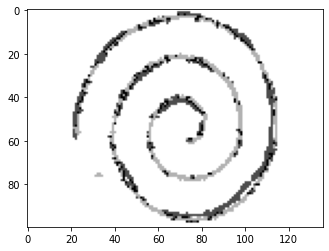

In [96]:
im = Image.fromarray((X_all[0]*255))
plt.imshow(im)
plt.show()

### Train-Test-Split

Consider random state and possibility for different train test validation sets.

In [97]:
y_label = y_all.copy()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, random_state = 0, test_size = 0.15, stratify = y_label)

In [99]:
len(y_train), len(y_test)

(863, 153)

In [100]:
# consider setting test_size to larger 

train_labels = y_train.copy()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0, test_size = 0.1, stratify = train_labels)

In [101]:
len(y_train), len(y_val)

(776, 87)

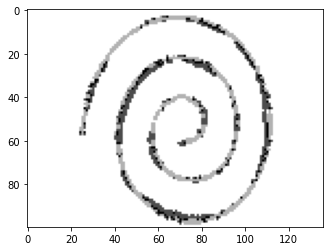

In [102]:
im = Image.fromarray((X_train[0] *255))
plt.imshow(im)
plt.show()

## Saving to Directories

In [103]:
# sequence level storage, no patient level rn

def save_to_directories(X, y, path):
  
  # convert numpy array to image
  for i in range(len(X)):
    label = y[i]
    # X[i] = X[i].astype('uint8') converts to 8 bit, bad for storage

    # find image's label, control or patient
    if label == 1:
      # save image to correct directory
      path_pd = path + "/Patient/image_{}.jpg".format(i+1)
      imageio.imwrite(path_pd, X[i])

    elif label == 0:
      path_control = path + "/Control/image_{}.jpg".format(i+1)
      imageio.imwrite(path_control, X[i])

In [ ]:
save_to_directories(X_train, y_train, "/content/drive/MyDrive/Data/Images/Split_Data/Train") # we'll ignore the warning for now
save_to_directories(X_val, y_val, "/content/drive/MyDrive/Data/Images/Split_Data/Validation") # we'll ignore the warning for now
save_to_directories(X_test, y_test, "/content/drive/MyDrive/Data/Images/Split_Data/Test") # we'll ignore the warning for now

## Loading Data into Tensorflow

In [ ]:
WIDTH = 137
HEIGHT = 100

In [ ]:
train_dir = "/content/drive/MyDrive/Data/Images/Split_Data/Train"
val_dir = "/content/drive/MyDrive/Data/Images/Split_Data/Validation"
test_dir = "/content/drive/MyDrive/Data/Images/Split_Data/Test"

In [ ]:
train_data = ImageDataGenerator()
val_data = ImageDataGenerator()
test_data = ImageDataGenerator()

In [ ]:
train_generator = train_data.flow_from_directory(
    train_dir, 
    target_size = (WIDTH, HEIGHT), 
    batch_size = 4, 
    class_mode = 'binary' 
)

val_generator = val_data.flow_from_directory(
    val_dir, 
    target_size = (WIDTH, HEIGHT), 
    batch_size = 4, 
    class_mode = 'binary' 
)

test_generator = test_data.flow_from_directory(
    test_dir, 
    target_size = (WIDTH, HEIGHT), 
    batch_size = 4, 
    class_mode = 'binary' 
)

Found 776 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


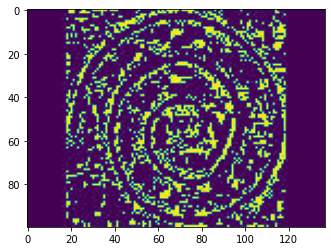

In [ ]:
im = Image.open("/content/drive/MyDrive/Data/Images/Split_Data/Train/Control/image_1.jpg")
plt.imshow(im)
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    #conv net part
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(100, 137, 1)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #dnn part
    tf.keras.layers.Flatten(),
   
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 98, 135, 16)       160       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 49, 67, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 47, 65, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 32, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 21, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 15, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 13, 64)        

In [ ]:
class callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
    #creating a callback function that activates if the accuracy is greater than 60%
        if (logs.get('accuracy') > 0.975):
          print("Stopping Training")
          self.model.stop_training = True
            
callbacks = callback()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate = 0.0001),
              metrics=['accuracy'])

In [ ]:
#training model after loading data in using an image generator
history = model.fit (
    #training part
    train_generator,
    steps_per_epoch = 4, 
    epochs = 15,
    
    #validation part
    validation_data = val_generator,
    validation_steps = 4,
    callbacks = [callbacks],
)

Epoch 1/15


UnimplementedError: ignored